In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
transforms = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(
    './data',
    train=True,
    download=True,
    transform=transforms)

test_dataset = datasets.MNIST(
    './data',
    train=False,
    download=True,
    transform=transforms
)

9920512it [00:01, 7205462.41it/s]                             


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz


32768it [00:00, 325269.27it/s]                           


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz


1654784it [00:00, 3491915.36it/s]                            


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz


8192it [00:00, 124417.88it/s]


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [3]:
BATCH_SIZE = 64         # number of data points in each batch
N_EPOCHS = 10           # times to run the model on complete data
INPUT_DIM = 28 * 28     # size of each input
HIDDEN_DIM = 256        # hidden dimension
LATENT_DIM = 75         # latent vector dimension
N_CLASSES = 10          # number of classes in the data
lr = 1e-3               # learning rate

In [4]:
train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_iterator = DataLoader(test_dataset, batch_size=BATCH_SIZE)

def idx2onehot(idx, n=N_CLASSES):

    assert idx.shape[1] == 1
    assert torch.max(idx).item() < n

    onehot = torch.zeros(idx.size(0), n)
    onehot.scatter_(1, idx.data, 1)

    return onehot

class Encoder(nn.Module):
    ''' This the encoder part of VAE

    '''
    def __init__(self, input_dim, hidden_dim, latent_dim, n_classes):
        '''
        Args:
            input_dim: A integer indicating the size of input (in case of MNIST 28 * 28).
            hidden_dim: A integer indicating the size of hidden dimension.
            latent_dim: A integer indicating the latent size.
            n_classes: A integer indicating the number of classes. (dimension of one-hot representation of labels)
        '''
        super().__init__()

        self.linear = nn.Linear(input_dim + n_classes, hidden_dim)
        self.mu = nn.Linear(hidden_dim, latent_dim)
        self.var = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        # x is of shape [batch_size, input_dim + n_classes]

        hidden = F.relu(self.linear(x))
        # hidden is of shape [batch_size, hidden_dim]

        # latent parameters
        mean = self.mu(hidden)
        # mean is of shape [batch_size, latent_dim]
        log_var = self.var(hidden)
        # log_var is of shape [batch_size, latent_dim]

        return mean, log_var
    
class Decoder(nn.Module):
    ''' This the decoder part of VAE

    '''
    def __init__(self, latent_dim, hidden_dim, output_dim, n_classes):
        '''
        Args:
            latent_dim: A integer indicating the latent size.
            hidden_dim: A integer indicating the size of hidden dimension.
            output_dim: A integer indicating the size of output (in case of MNIST 28 * 28).
            n_classes: A integer indicating the number of classes. (dimension of one-hot representation of labels)
        '''
        super().__init__()

        self.latent_to_hidden = nn.Linear(latent_dim + n_classes, hidden_dim)
        self.hidden_to_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x is of shape [batch_size, latent_dim + num_classes]
        x = F.relu(self.latent_to_hidden(x))
        # x is of shape [batch_size, hidden_dim]
        generated_x = F.sigmoid(self.hidden_to_out(x))
        # x is of shape [batch_size, output_dim]

        return generated_x
    
class CVAE(nn.Module):
    ''' This the VAE, which takes a encoder and decoder.

    '''
    def __init__(self, input_dim, hidden_dim, latent_dim, n_classes):
        '''
        Args:
            input_dim: A integer indicating the size of input (in case of MNIST 28 * 28).
            hidden_dim: A integer indicating the size of hidden dimension.
            latent_dim: A integer indicating the latent size.
            n_classes: A integer indicating the number of classes. (dimension of one-hot representation of labels)
        '''
        super().__init__()

        self.encoder = Encoder(input_dim, hidden_dim, latent_dim, n_classes)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim, n_classes)

    def forward(self, x, y):

        x = torch.cat((x, y), dim=1)

        # encode
        z_mu, z_var = self.encoder(x)

        # sample from the distribution having latent parameters z_mu, z_var
        # reparameterize
        std = torch.exp(z_var / 2)
        eps = torch.randn_like(std)
        x_sample = eps.mul(std).add_(z_mu)

        z = torch.cat((x_sample, y), dim=1)

        # decode
        generated_x = self.decoder(z)

        return generated_x, z_mu, z_var

In [5]:
def calculate_loss(x, reconstructed_x, mean, log_var):
    # reconstruction loss
    RCL = F.binary_cross_entropy(reconstructed_x, x, size_average=False)
    # kl divergence loss
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return RCL + KLD

def train():
    # set the train mode
    model.train()

    # loss of the epoch
    train_loss = 0

    for i, (x, y) in enumerate(train_iterator):
        # reshape the data into [batch_size, 784]
        x = x.view(-1, 28 * 28)
        x = x.to(device)

        # convert y into one-hot encoding
        y = idx2onehot(y.view(-1, 1))
        y = y.to(device)

        # update the gradients to zero
        optimizer.zero_grad()

        # forward pass
        reconstructed_x, z_mu, z_var = model(x, y)

        # loss
        loss = calculate_loss(x, reconstructed_x, z_mu, z_var)

        # backward pass
        loss.backward()
        train_loss += loss.item()

        # update the weights
        optimizer.step()

    return train_loss

def test():
    # set the evaluation mode
    model.eval()

    # test loss for the data
    test_loss = 0

    # we don't need to track the gradients, since we are not updating the parameters during evaluation / testing
    with torch.no_grad():
        for i, (x, y) in enumerate(test_iterator):
            # reshape the data
            x = x.view(-1, 28 * 28)
            x = x.to(device)

            # convert y into one-hot encoding
            y = idx2onehot(y.view(-1, 1))
            y = y.to(device)

            # forward pass
            reconstructed_x, z_mu, z_var = model(x, y)

            # loss
            loss = calculate_loss(x, reconstructed_x, z_mu, z_var)
            test_loss += loss.item()

    return test_loss


In [8]:
# model
model = CVAE(INPUT_DIM, HIDDEN_DIM, LATENT_DIM, N_CLASSES)
model.to(device)
#optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
best_test_loss = 9999
for e in range(N_EPOCHS):

    train_loss = train()
    test_loss = test()

    train_loss /= len(train_dataset)
    test_loss /= len(test_dataset)

    print(f'Epoch {e}, Train Loss: {train_loss:.2f}, Test Loss: {test_loss:.2f}')

    if best_test_loss > test_loss:
        best_test_loss = test_loss
        patience_counter = 1
    else:
        patience_counter += 1

    if patience_counter > 3:
        break

Epoch 0, Train Loss: 160.09, Test Loss: 128.44
Epoch 1, Train Loss: 121.54, Test Loss: 114.80
Epoch 2, Train Loss: 112.97, Test Loss: 109.87
Epoch 3, Train Loss: 109.37, Test Loss: 107.24
Epoch 4, Train Loss: 107.36, Test Loss: 105.98
Epoch 5, Train Loss: 105.99, Test Loss: 104.86
Epoch 6, Train Loss: 105.03, Test Loss: 104.08
Epoch 7, Train Loss: 104.27, Test Loss: 103.81
Epoch 8, Train Loss: 103.71, Test Loss: 103.10
Epoch 9, Train Loss: 103.23, Test Loss: 102.49


Generating a 6


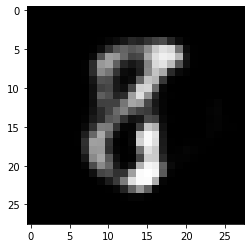

0.09516751
Generating a 4


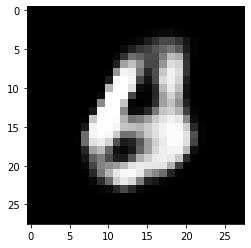

0.1618485
Generating a 5


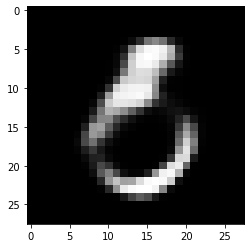

0.10822709
Generating a 4


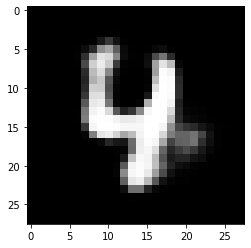

0.13934363
Generating a 2


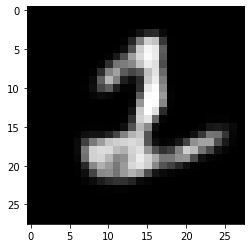

0.10520089
Generating a 3


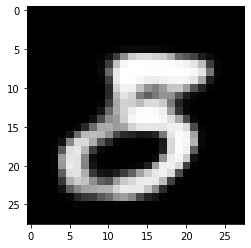

0.19881651
Generating a 0


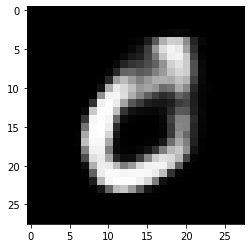

0.14787528
Generating a 2


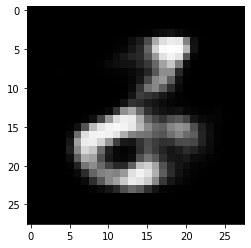

0.11102188
Generating a 2


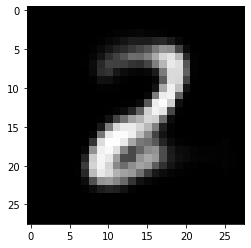

0.10122165
Generating a 2


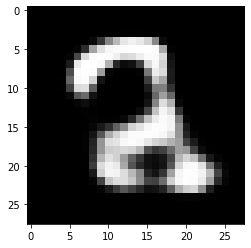

0.17486164


In [17]:
# create a random latent vector

def generateImage(model):
    z = torch.randn(1, LATENT_DIM).to(device)

    # pick randomly 1 class, for which we want to generate the data
    y = torch.randint(0, N_CLASSES, (1, 1)).to(dtype=torch.long)
    print(f'Generating a {y.item()}')

    y = idx2onehot(y).to(device, dtype=z.dtype)
    z = torch.cat((z, y), dim=1)

    reconstructed_img = model.decoder(z)
    img = reconstructed_img.view(28, 28).data

    plt.figure()
    plt.imshow(img.cpu(), cmap='gray')
    plt.show()
    print(np.mean(img.cpu().numpy()))
    
for i in range(10):
    generateImage(model)